In [1]:
import numpy as np
import scipy.stats
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

plt.rcParams['figure.figsize'] = [13, 5]

In [24]:
omega = 1.0
rho = 0.05
tau = 0.5
beta = 0.27
T = 15
initial_dist = scipy.stats.norm(np.power(2, -0.5), 0.5)

xi = 1/np.sqrt(rho)
# xi = 0

# phi = lambda x: beta*jnp.sign(x);
phi = lambda x: np.zeros_like(x)

# Discretization
Nx = 50
Nt = 100

xs = np.linspace(-5, 5, Nx)
dx = xs[1] - xs[0]
ts = np.linspace(0, T, Nt)
dt = ts[1] - ts[0]

In [25]:
def calculate_gamma(x, xi, qt, rt):
    y = tau*omega*qt*xi - phi(x)
    y -= x*(tau*omega*np.square(qt) - rt + 0.5*np.square(tau)*(1+omega*np.square(qt)))
    return y

def calculate_q(Pt, xs):
    return np.sqrt(rho)*np.dot(Pt, xs)*dx

def calculate_r(Pt, xs):
    px = phi(xs)
    return np.dot(xs*px, Pt)*dx


def d_central(fun, dx, order):
    kernels = {
        1: np.array([-0.5, 0, 0.5]) / dx,
        2: np.array([1, -2, 1]) / np.square(dx),
    }
    
    kernel = kernels[order]
    return np.convolve(np.pad(fun, (1, 1)), kernel, mode='valid')

In [26]:
P = np.zeros((Nt, Nx))
ddP = np.zeros((Nt, Nx))
Gamma = np.zeros((Nt, Nx))
dP = np.zeros((Nt, Nx))
dPdt = np.zeros((Nt, Nx))

Q = np.zeros(Nt)
P[0] = initial_dist.pdf(xs)

for t in range(0,Nt-1):
    Pt = P[t]
    qt = calculate_q(Pt, xs)
    rt = calculate_r(Pt, xs)

    gp = calculate_gamma(xs, xi, qt, rt)
    dgp = d_central(gp*Pt, dx, 1)
        
    ddp = 0.5*np.square(tau)*(1 + omega*np.square(qt))*d_central(Pt, dx, 2)

    P[t+1] = Pt + (-dgp + ddp)*dt
    Q[t] = qt
    ddP[t] = ddp
    dP[t] = dgp
    Gamma[t] = gp
    dPdt[t] = ddp - dgp

In [27]:
inter_vars = {
    'P': P,
    'dP': dP,
    'ddP': ddP,
    'dPdt': dPdt,
    'gamma': Gamma
}

def plot_p(t=0, var='P'):
    plt.plot(xs, inter_vars[var][t])
    # plt.ylim((0, 1))
    
    plt.xlabel("$x$")
    plt.ylabel(f"{var}")

t_slider = widgets.IntSlider(min=0, max=Nt-1, step=1, value=0)
var_select = widgets.Dropdown(options=inter_vars.keys())
interact(plot_p, t=t_slider, var=var_select);

interactive(children=(IntSlider(value=0, description='t', max=99), Dropdown(description='var', options=('P', '…

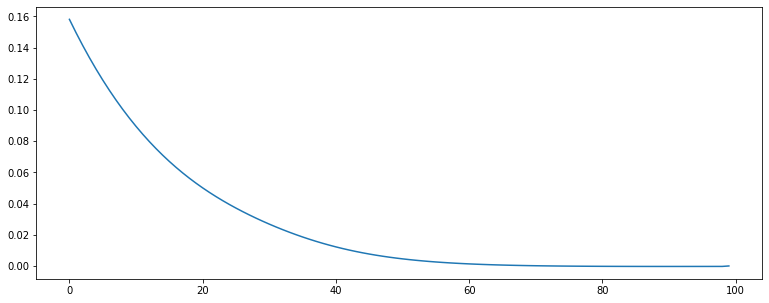

In [28]:
plt.plot(Q)